Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


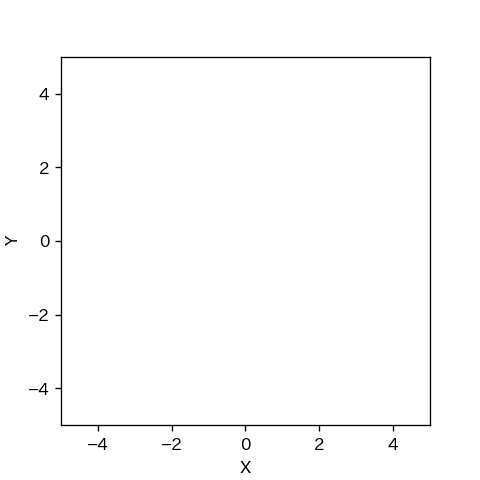

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_phantom_trap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


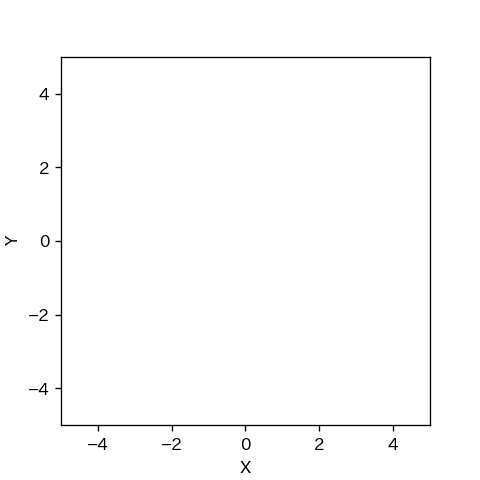

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_phantom_trap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_trap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [0.70610935 2.04916507 2.56186573] 推定値: [-0.70346477  2.93603405  2.75372991] 誤差: 1.6653635606155817
1 真値: [0.88868276 0.46081938 0.9543101 ] 推定値: [ 1.4748696  -0.02738148  1.08575495] 誤差: 0.7628598122789176
1
2 真値: [-0.01924607  2.67546527  3.3042613 ] 推定値: [-0.22184615  2.24038722  3.09463817] 誤差: 0.47993719215780356
2
3 真値: [0.66504664 1.79349494 2.35487858] 推定値: [0.98077159 2.6409301  2.51708401] 誤差: 0.904338765458165
3
4 真値: [1.02684957 0.90114622 1.35959152] 推定値: [1.78022096 0.48489995 1.67424577] 誤差: 0.8607144778433428
4
5 真値: [0.66037269 2.59545538 2.81685295] 推定値: [0.77532146 1.79558575 2.54451365] 誤差: 0.8080870301849477
5
6 真値: [-0.45927607  2.16543174  3.39420061] 推定値: [-0.89703527  2.28645442  3.44989996] 誤差: 0.4541801482837225
6
7 真値: [0.66444362 1.98226848 2.56976229] 推定値: [0.59140737 2.11520784 2.56738859] 誤差: 0.1516811348996477
7
8 真値: [-0.88015359  1.77863547  3.80190797] 推定値: [-1.28933187  2.04735405  3.81285431] 誤差: 0.4895268546630085
8
9 真値: [1.0953976  2.1746

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [0.95876634 1.5538508  2.02642461] 推定値: [-0.05467948  4.14671484  2.59646824] 誤差: 2.783885117100243
21 真値: [0.96315975 1.35545661 1.8254625 ] 推定値: [0.07365935 2.91445079 2.28805786] 誤差: 1.794902174520276
22 真値: [-0.76786648  1.6551804   4.21185701] 推定値: [-1.18724041  1.82707415  4.03253902] 誤差: 0.45323498205658247
16
23 真値: [0.82358221 2.17426927 2.66680538] 推定値: [0.61237247 1.05257213 2.35707421] 誤差: 1.1414087875530967
24 真値: [1.15627441 1.97192743 2.10327108] 推定値: [0.46756609 2.60910206 2.22715838] 誤差: 0.9382487194668745
17
25 真値: [1.13085664 0.91344275 1.35810522] 推定値: [1.39748512 1.17891463 1.62991772] 誤差: 0.37625266035251775
18
26 真値: [1.50040354 1.38364563 1.4814769 ] 推定値: [2.2530747  0.90459855 1.89925438] 誤差: 0.8921883145098849
19
27 真値: [0.03784298 2.21622979 2.9401508 ] 推定値: [0.59909628 2.40348451 2.98266474] 誤差: 0.5916667926144987
20
28 真値: [0.69218505 2.38033379 2.21540087] 推定値: [-0.29486085  3.61008686  2.5164914 ] 誤差: 1.5768805366793004
29 真値: [0.61864605 1.9874837